In [0]:
import time, random
import numpy as np
from PIL import Image
from scipy import stats
from imageio import imsave
import matplotlib.pyplot as plt
from itertools import permutations
from skimage.util.shape import view_as_blocks

from torchvision import datasets

In [0]:
# Global shuffle key
map={}
def shuffle(im, num, inverse = False):
  '''
  Shuffles an RGB image 'im' (shape - s x s) into 'num x num' blocks
  Rows and columns should be  divisible by 'num'
  '''
  global map
  rows=cols=num
  blk_size=np.uint8(im.shape[0]/rows)
  print(type(blk_size))

  img_blks=view_as_blocks(im,block_shape=(blk_size,blk_size,3)).reshape((-1,blk_size,blk_size,3))
  img_shuff=np.zeros((im.shape[0], im.shape[0],3),dtype=np.uint8)
  
  a=np.arange(rows*rows, dtype=np.uint8)
  b=np.random.permutation(a)

  if(inverse):
      inv_map = {v: k for k, v in map.items()}
      print("Inverse Map:-\n" + str(inv_map)) 
  else:
      map = {k:v for k,v in zip(a,b)}
      print("Key Map:-\n" + str(map))

  for i in range(0,rows):
    for j in range(0,cols):
      x,y = i*blk_size, j*blk_size
      if(inverse):
        img_shuff[x:x+blk_size, y:y+blk_size] = img_blks[inv_map[i*rows + j]]
      else:
        img_shuff[x:x+blk_size, y:y+blk_size] = img_blks[map[i*rows + j]] 
  return img_shuff

In [0]:
def unscramble(shuf, orig, num):
  '''
  Decodes the shuffled image to recover the original image.
  Uses brute force method of iterating over permutations.
  shuf - shuffled image (RGB)
  orig - original image (RGB)
  num - number of blocks in a row (column)
  '''
  perm_map={}
  rows=cols=num
  blk_size=shuf.shape[0]//rows

  orig_blk=view_as_blocks(orig,block_shape=(blk_size,blk_size,3)).reshape((-1,blk_size,blk_size,3))
  img_blks=view_as_blocks(shuf,block_shape=(blk_size,blk_size,3)).reshape((-1,blk_size,blk_size,3))
  
  img_shuff=np.zeros((shuf.shape[0], shuf.shape[0],3),dtype=np.uint8)

  i=0;
  for x in permutations(np.arange(0,9)):
      
      perm_blk = img_blks[x,...]
      if not np.any(orig_blk - perm_blk):
          print("Result\n")
          print(perm_blk)
          print("Original\n")
          print(orig_blk)
          print("\nFound at last !!!\n")
          print('Iteration: '+ str(i))
          break
      else:
          i=i+1
          #print('Iter: '+ str(i) + ' Still not found ...',end='\r')

Load the source image and generate a shuffled image for testing

In [16]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Deep Learning 2020 -- Home Assignment 2")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
else:
    AUX_DATA_ROOT = Path(".")

# Extract the dataset into the current directory
if not Path("tiny-imagenet-200/train/class_000/00000.jpg").is_file():
    import zipfile
    with zipfile.ZipFile(AUX_DATA_ROOT / 'tiny-imagenet-2020.zip', 'r') as archive:
        archive.extractall()
import os
data_dir = './tiny-imagenet-200/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
image_datasets = {'train': datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          transforms.ToTensor()),
                  'val': datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                          transforms.ToTensor())
                  }
import torch 
batch_size = 32
train_batch_gen = torch.utils.data.DataLoader(image_datasets['train'], batch_size= batch_size, 
                                                    shuffle=True, num_workers=4)
batch_size_val = 32
val_batch_gen = torch.utils.data.DataLoader(image_datasets['val'], batch_size= batch_size_val, 
                                                  shuffle=True, num_workers=4)

torch.Size([3, 68, 464])


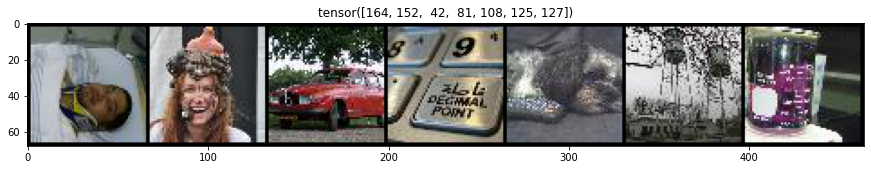

In [63]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15,15))
    plt.imshow(inp)
    plt.title(str(title))

n_show = 7
inputs, classes = next(iter(train_batch_gen))
out = torchvision.utils.make_grid(inputs[:n_show])
print(out.shape)
imshow(out, classes[:n_show])

<class 'numpy.uint8'>
Key Map:-
{0: 3, 1: 10, 2: 12, 3: 14, 4: 8, 5: 7, 6: 0, 7: 2, 8: 5, 9: 9, 10: 1, 11: 4, 12: 13, 13: 6, 14: 11, 15: 15}
<class 'numpy.uint8'>
Inverse Map:-
{3: 0, 10: 1, 12: 2, 14: 3, 8: 4, 7: 5, 0: 6, 2: 7, 5: 8, 9: 9, 1: 10, 4: 11, 13: 12, 6: 13, 11: 14, 15: 15}


<Figure size 432x288 with 0 Axes>

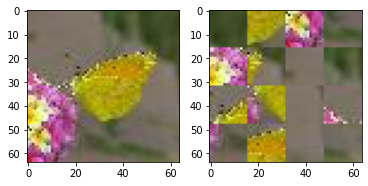

In [79]:
# Load an image
im=np.array(Image.open('/content/tiny-imagenet-200/train/class_000/00000.jpg').convert('RGB'))
im.shape

# Test shuffle function using 'key map' and num_blocks=3
shuff=shuffle(im,4, inverse=False)
reverted=shuffle(shuff,4, inverse=True)

# Save the shuffled and decoded images
imsave("0_shuf.png",shuff)
imsave("0_prop.png",reverted)

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(reverted)
axarr[1].imshow(shuff)